# Set up

In [104]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
return false;
}

<IPython.core.display.Javascript object>

In [105]:
import matplotlib.pyplot as plt
import gstlearn as gl
import gstlearn.plot as gp
import numpy as np
import pandas as pd
import scipy as sp
from scipy import interpolate
import os
import urllib.request

In [106]:
#!pip install -i https://test.pypi.org/simple/ gstlearn
#!pip uninstall -y gstlearn
#!pip3 install numpy --upgrade

# Load Data

In [108]:
url = 'https://soft.minesparis.psl.eu/gstlearn/data/Alluvial/Oise_GridVectorFinal.ascii'
filename, head = urllib.request.urlretrieve(url)
grid = gl.DbGrid.createFromNF(filename)
grid


Data Base Grid Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 2
Number of Columns            = 9
Maximum Number of UIDs       = 9
Total number of samples      = 1320000
Number of active samples     = 278129

Grid characteristics:
---------------------
Origin : 630000.0006865000.000
Mesh   :     50.000    50.000
Number :       3300       400
Rotation Angles        =     40.000     0.000
Direct Rotation Matrix
               [,  0]    [,  1]
     [  0,]     0.766    -0.643
     [  1,]     0.643     0.766
Inverse Rotation Matrix
               [,  0]    [,  1]
     [  0,]     0.766     0.643
     [  1,]    -0.643     0.766

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = x1 - Locator = x1
Column = 2 - Name = x2 - Locator = x2
Column = 3 - Name = Polygon - Locator = NA
Column = 4 - Name = Migrate.u_interp - Locator = z1
Column = 5 - Name = Migrate.v_interp - Locator = z2
Column = 6 - N

In [109]:
ranges = [500,10000]
oldMethod = False

In [110]:
url = 'https://soft.minesparis.psl.eu/gstlearn/data/Alluvial/Oise_Data.ascii'
filename, head = urllib.request.urlretrieve(url)
data = gl.Db.createFromNF(filename)
data


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 7
Maximum Number of UIDs       = 7
Total number of samples      = 1022
Number of active samples     = 1007

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = X - Locator = x1
Column = 2 - Name = Y - Locator = x2
Column = 3 - Name = Epaisseur - Locator = lower1
Column = 4 - Name = Epaisseur_1 - Locator = upper1
Column = 5 - Name = Thickness - Locator = z1
Column = 6 - Name = Duplicate - Locator = sel

# Krigeage SPDE


Variogram characteristics
Number of variable(s)       = 1
Number of direction(s)      = 2
Space dimension             = 2
Variance-Covariance Matrix     8.308

Direction #1
------------
Number of lags              = 40
Direction coefficients      =      1.000     1.000
Direction angles (degrees)  =     45.000     0.000
Tolerance on direction      =     45.000 (degrees)
Calculation lag             =    800.000
Tolerance on distance       =     50.000 (Percent of the lag value)

For variable 1
      Rank    Npairs  Distance     Value
         0  1490.000   223.076     4.288
         1  4135.000   817.513     6.027
         2  4998.000  1597.587     5.765
         3  5136.000  2402.372     7.172
         4  4916.000  3203.179     7.076
         5  5370.000  3996.268     6.865
         6  5948.000  4804.243     6.811
         7  5990.000  5607.329     6.236
         8  5883.000  6392.169     6.132
         9  5766.000  7198.769     7.205
        10  5597.000  8003.510     6.703
        11

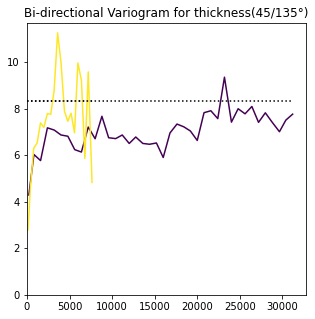

In [111]:
myVarioParamBidir = gl.VarioParam()
mydir = gl.DirParam(40,800.,0.5,45.,0,0,np.nan,np.nan,0.,[],[1,1])
myVarioParamBidir.addDir(mydir)
mydir = gl.DirParam(20,400.,0.5,45.,0,0,np.nan,np.nan,0.,[],[-1,1])
myVarioParamBidir.addDir(mydir)
myVarioBidir = gl.Vario(myVarioParamBidir,data)
err = myVarioBidir.compute(gl.ECalcVario.VARIOGRAM)
myVarioBidir.display()
ax = gp.varmod(myVarioBidir,idir=0)
ax.decoration(title="Bi-directional Variogram for thickness(45°)")
ax = gp.varmod(myVarioBidir,idir=1)
ax.decoration(title="Bi-directional Variogram for thickness(45/135°)")


Model characteristics
Space dimension              = 2
Number of variable(s)        = 1
Number of basic structure(s) = 2
Number of drift function(s)  = 0
Number of drift equation(s)  = 0

Covariance Part
---------------
Nugget Effect
- Sill         =      2.215
K-Bessel (Third Parameter = 1)
- Sill         =      4.700
- Ranges       =   1046.558  1497.411
- Theo. Ranges =    302.115   432.265
- Angles       =     45.000     0.000
- Rotation Matrix
               [,  0]    [,  1]
     [  0,]     0.707    -0.707
     [  1,]     0.707     0.707
Total Sill     =      6.915
 

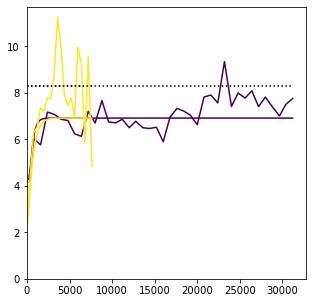

In [112]:
model = gl.Model.createFromDb(data)


structs = [gl.ECov.NUGGET,gl.ECov.BESSEL_K]

#consNug = gl.ConsItem.define(gl.EConsElem.SILL,0, type = gl.EConsType.UPPER,value = 0.1)

cons1P = gl.ConsItem.define(gl.EConsElem.PARAM,1, type = gl.EConsType.EQUAL,value = 1)
#cons1Rm = gl.ConsItem.define(gl.EConsElem.RANGE,1, type = gl.EConsType.LOWER,value = 100)
#cons1RM = gl.ConsItem.define(gl.EConsElem.RANGE,1, type = gl.EConsType.UPPER,value = 350)

#cons2P = gl.ConsItem.define(gl.EConsElem.PARAM,2, type = gl.EConsType.EQUAL,value = 2)
#cons2Rm = gl.ConsItem.define(gl.EConsElem.RANGE,2, type = gl.EConsType.LOWER,value = 100)
#cons2RM = gl.ConsItem.define(gl.EConsElem.RANGE,2, type = gl.EConsType.UPPER,value = 400)

a = gl.Constraints()
#a.addItem(consNug)
a.addItem(cons1P)
#a.addItem(cons1Rm)
#a.addItem(cons1RM)
#a.addItem(cons2P)
#a.addItem(cons2Rm)
#a.addItem(cons2RM)

err = model.fit(myVarioBidir,structs,constraints=a)


#err = model.fit(myVarioBidir,[gl.ECov.NUGGET,gl.ECov.BESSEL_K,gl.ECov.BESSEL_K], False)

model.display()
ax = gp.varmod(myVarioBidir,model,idir=0)
ax = gp.varmod(myVarioBidir,model,idir=1)

In [113]:
if not oldMethod :
    model = gl.Model.createFromDb(data)
    covBessel = gl.CovAniso.createAnisotropic(type = gl.ECov.BESSEL_K,ranges=ranges,sill=4.7,param=1,ctxt=model.getContext())
    covNugget = gl.CovAniso.createIsotropic(type = gl.ECov.NUGGET,sill=2.2,ctxt=model.getContext(),range=1)
    model.addCov(covNugget)
    model.addCov(covBessel)


In [114]:
grid.setLocator("Poly*", gl.ELoc.SEL)
#grid.setLocator("Poly*",gl.ELoc.UNKNOWN)

In [115]:
model.setDriftIRF(order = 0)
model


Model characteristics
Space dimension              = 2
Number of variable(s)        = 1
Number of basic structure(s) = 2
Number of drift function(s)  = 1
Number of drift equation(s)  = 1

Covariance Part
---------------
Nugget Effect
- Sill         =      2.200
K-Bessel (Third Parameter = 1)
- Sill         =      4.700
- Ranges       =    500.000 10000.000
- Theo. Ranges =    144.338  2886.751
Total Sill     =      6.900

Drift Part
----------
Universality Condition

In [116]:
u = grid["Migrate.u_interp"]
v = grid["Migrate.v_interp"]
res = 0. * u
for i in range(u.shape[0]):
    codir = gl.VectorDouble()
    codir.push_back(u[i])
    codir.push_back(v[i])
    res[i] = gl.GH.rotationGetAngles(codir)[0]
    

In [117]:
grid.deleteColumn("angles*")
if not oldMethod:
    grid["angles1"]= res
    grid.setLocator("angles*",gl.ELoc.NOSTAT)
    nostat = gl.NoStatArray(["M2A"],grid)
    model.addNoStat(nostat)

In [118]:
grid.deleteColumns(["spde*"])


In [119]:
data


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 7
Maximum Number of UIDs       = 7
Total number of samples      = 1022
Number of active samples     = 1007

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = X - Locator = x1
Column = 2 - Name = Y - Locator = x2
Column = 3 - Name = Epaisseur - Locator = lower1
Column = 4 - Name = Epaisseur_1 - Locator = upper1
Column = 5 - Name = Thickness - Locator = z1
Column = 6 - Name = Duplicate - Locator = sel

In [120]:
spde = gl.SPDE(model,grid,data,gl.ESPDECalcMode.KRIGING)

In [121]:
spde.compute()

In [122]:
uid_result= spde.query(grid)
grid


Data Base Grid Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 2
Number of Columns            = 10
Maximum Number of UIDs       = 11
Total number of samples      = 1320000
Number of active samples     = 138248

Grid characteristics:
---------------------
Origin : 630000.0006865000.000
Mesh   :     50.000    50.000
Number :       3300       400
Rotation Angles        =     40.000     0.000
Direct Rotation Matrix
               [,  0]    [,  1]
     [  0,]     0.766    -0.643
     [  1,]     0.643     0.766
Inverse Rotation Matrix
               [,  0]    [,  1]
     [  0,]     0.766     0.643
     [  1,]    -0.643     0.766

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = x1 - Locator = x1
Column = 2 - Name = x2 - Locator = x2
Column = 3 - Name = Polygon - Locator = sel
Column = 4 - Name = Migrate.u_interp - Locator = NA
Column = 5 - Name = Migrate.v_interp - Locator = NA
Column = 6 

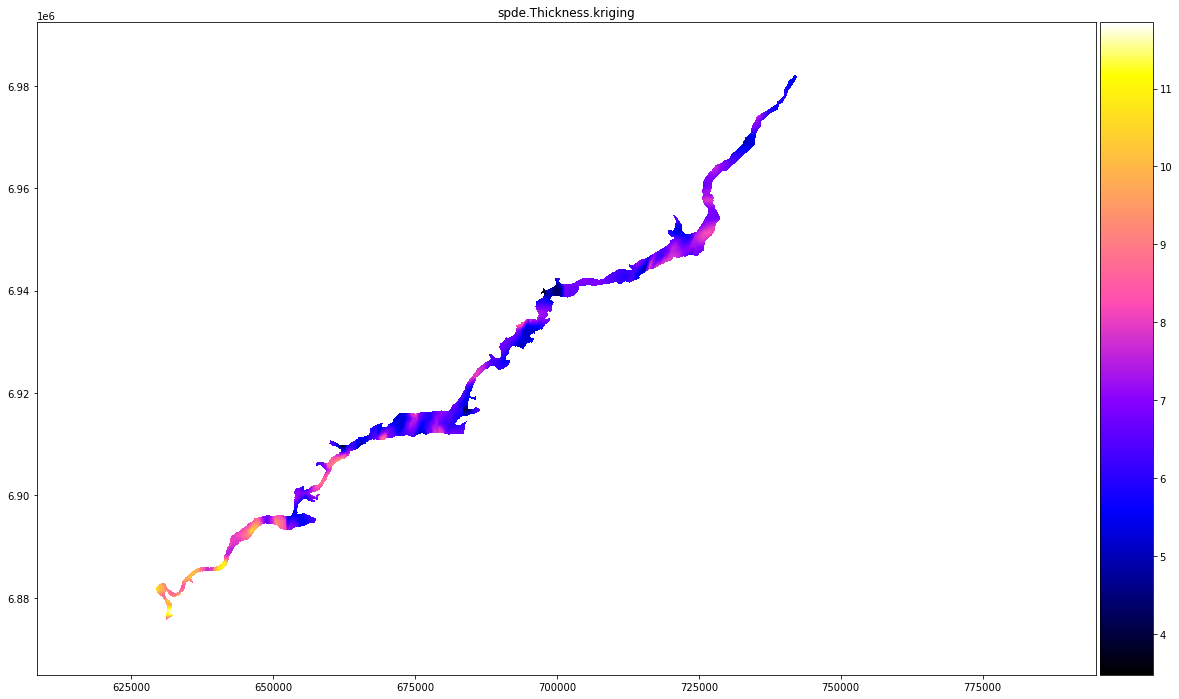

In [127]:
#fig,ax = gp.initGeographic()
#ax.raster(grid,"spde*kriging",cmap="gnuplot2", flagLegend = True)
plt.figure(figsize=[20,12])
gp.raster(grid,"spde*kriging",cmap="gnuplot2", flagLegend = True)

 # Prepare Export to ArcGIS

In [124]:
#Kriging data to new grid
#raster = gl.DbGrid()
#raster.reset([2400,2600],[50,50],[625000,6870000],[0,0])
#gl.migrate(grid, raster, "spde.Thickness.kriging",2,[100,100],True)

In [125]:
# Export Kriging grid to Ascii for Raster format => raster.gridwrite.format("arcgis","filename.txt")
#Kri=raster.getColumn("Migrate.spde.Thickness.kriging")
#len(Kri)
#KriG= np.array(Kri)
#KriG = np.where(KriG > 1000, -999999, KriG)
#KriG= np.where(KriG==0, -999999, KriG) 
#np.savetxt("filename.txt", KriG)